# AIoT Project 2023

In [1]:
import os

# basic data engineering
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import seaborn as sns

# db
import pymongo

# configs & other
import yaml
from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time

from psynlig import pca_explained_variance_bar

# utils processing
from utils import sliding_window_pd
from utils import filter_instances
from utils import transform_to_frequency_domain
from utils import find_best_order_aic
from utils import calculate_avg_cutoff_frequency

# utils visualization
from utils_visual import plot_instance_time_domain
from utils_visual import plot_instance_3d
from utils_visual import plot_heatmap
from utils_visual import plot_scatter_pca

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Start time of execution
time_start = time()

## Load configuration

In [3]:
config_path = os.path.join(os.getcwd(), "config.yml")

with open(config_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [4]:
client = pymongo.MongoClient(config["client"])

In [5]:
db = client[config["db"]]
coll = db[config["col"]]

In [6]:
class_labels = coll.distinct("label")
print("Existing DB keys:", class_labels)

Existing DB keys: ['CLASS_A', 'CLASS_B', 'CLASS_C', 'CLASS_D', 'CLASS_E', 'CLASS_F']


## Retrieve Data

In [7]:
# list of list of data instances per class
gestures = []

# for each gesture
for i, label in enumerate(class_labels):
    # df list for each class
    cls_instances = []
    # retrieve data
    label_data = coll.find({"label": label})
    # for each sample in gesture class
    for instance in label_data:
        # convert and formulate to df
        df_instance = pd.DataFrame(instance['data'])# .loc[:, 'acc_x':'acc_z']
        # append to related class list
        cls_instances.append(df_instance)
    # append to total
    gestures.append(cls_instances)

In [8]:
cls_a, cls_b, cls_c, cls_d, cls_e, cls_f = gestures

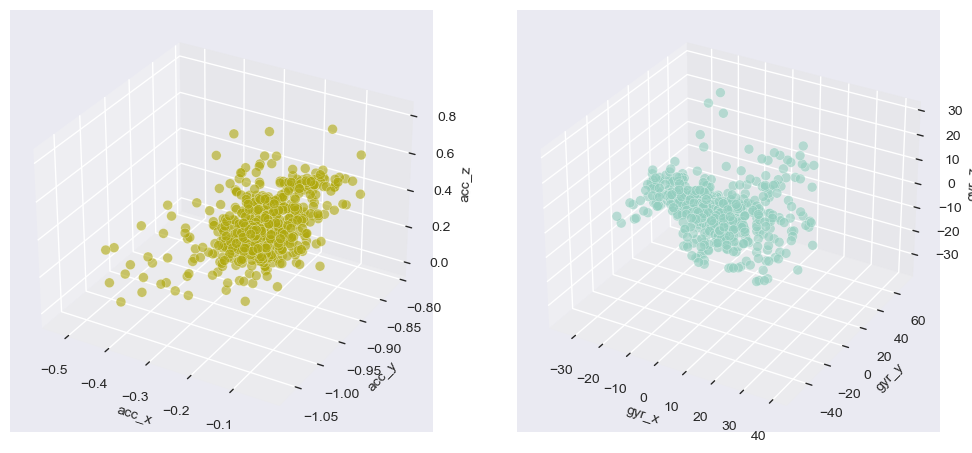

In [9]:
# 3D view of gyroscope and accelerometer axes of a random gesture instance
plot_instance_3d(cls_a[0])

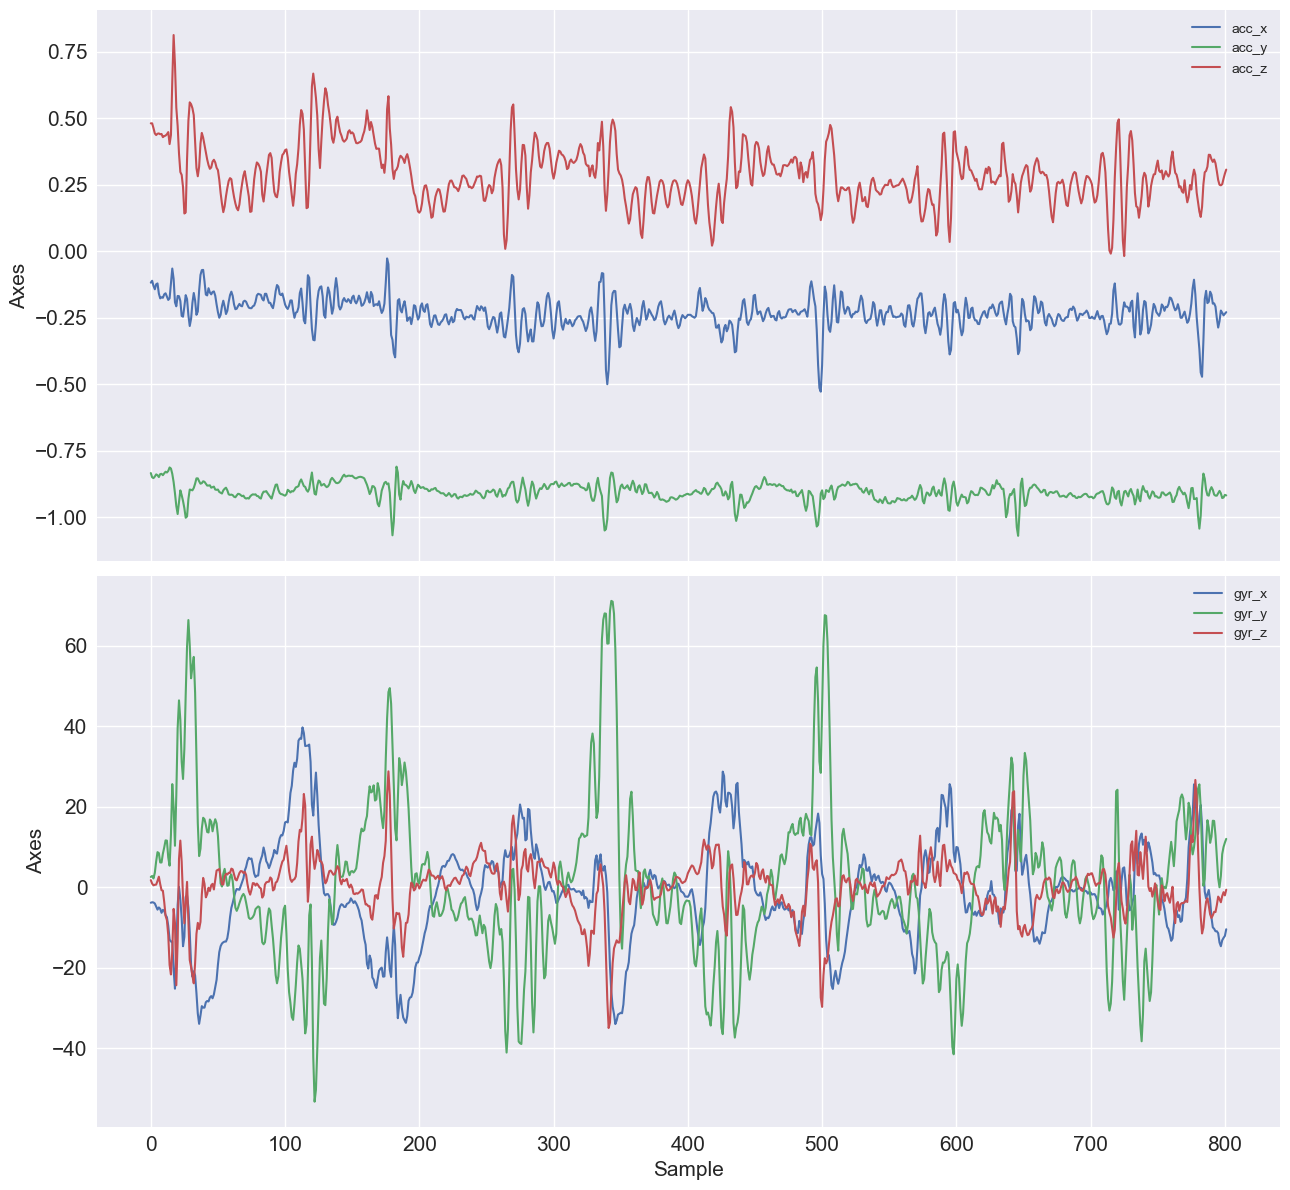

In [10]:
# wave gesture sample
plot_instance_time_domain(cls_a[0])

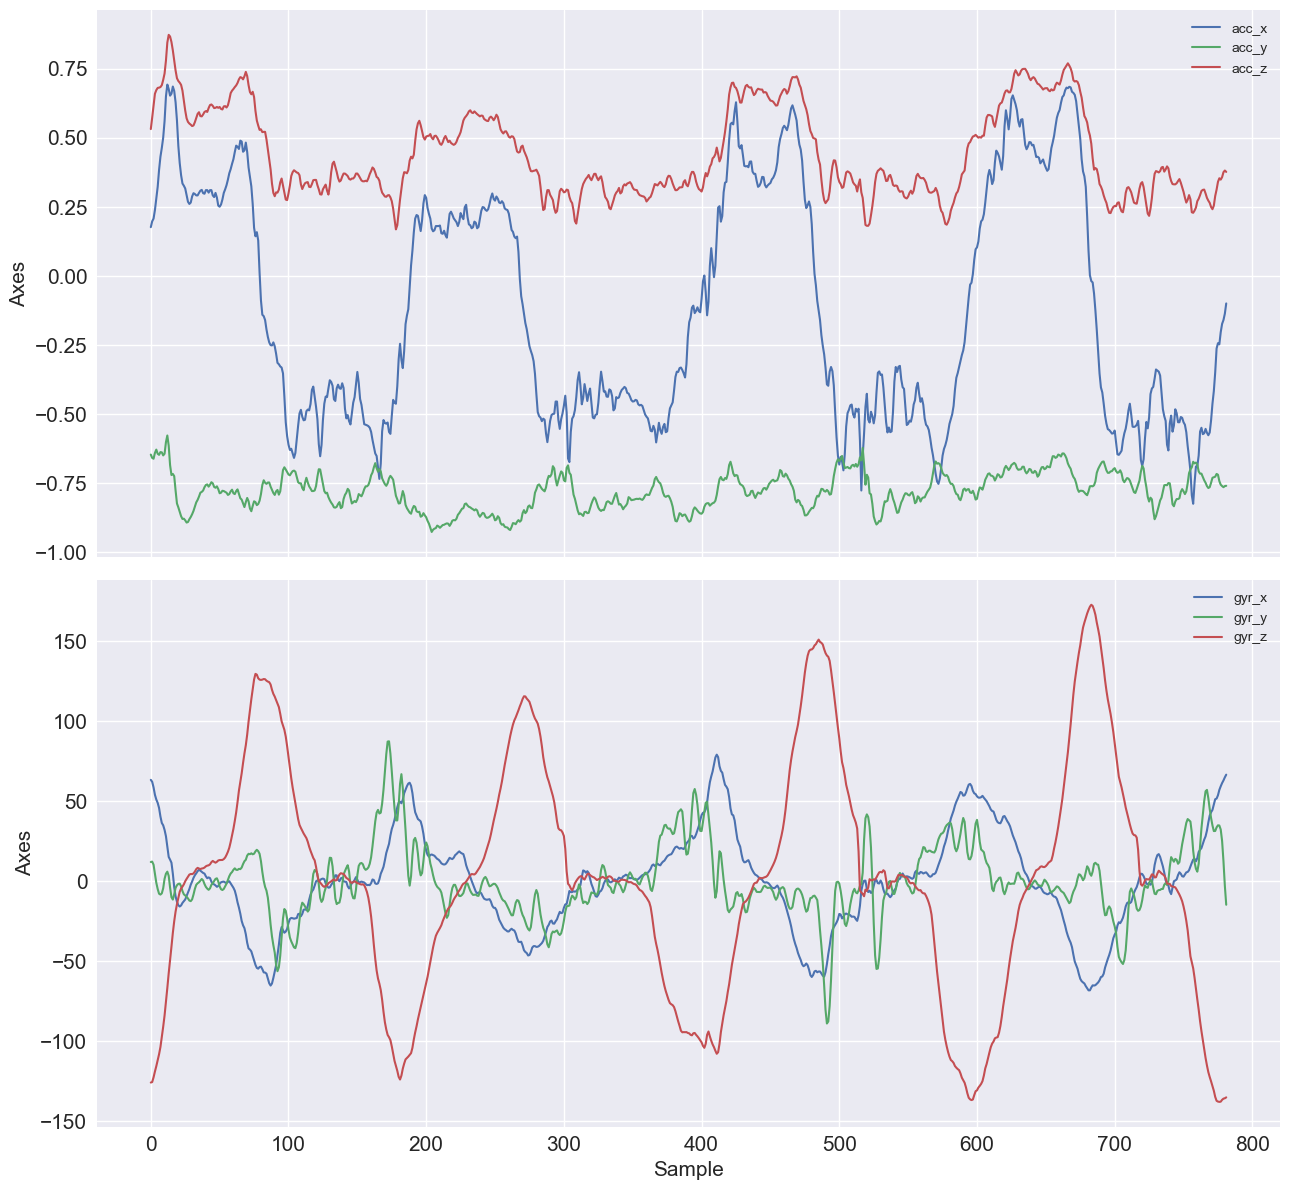

In [11]:
# wave gesture sample
plot_instance_time_domain(cls_b[0])

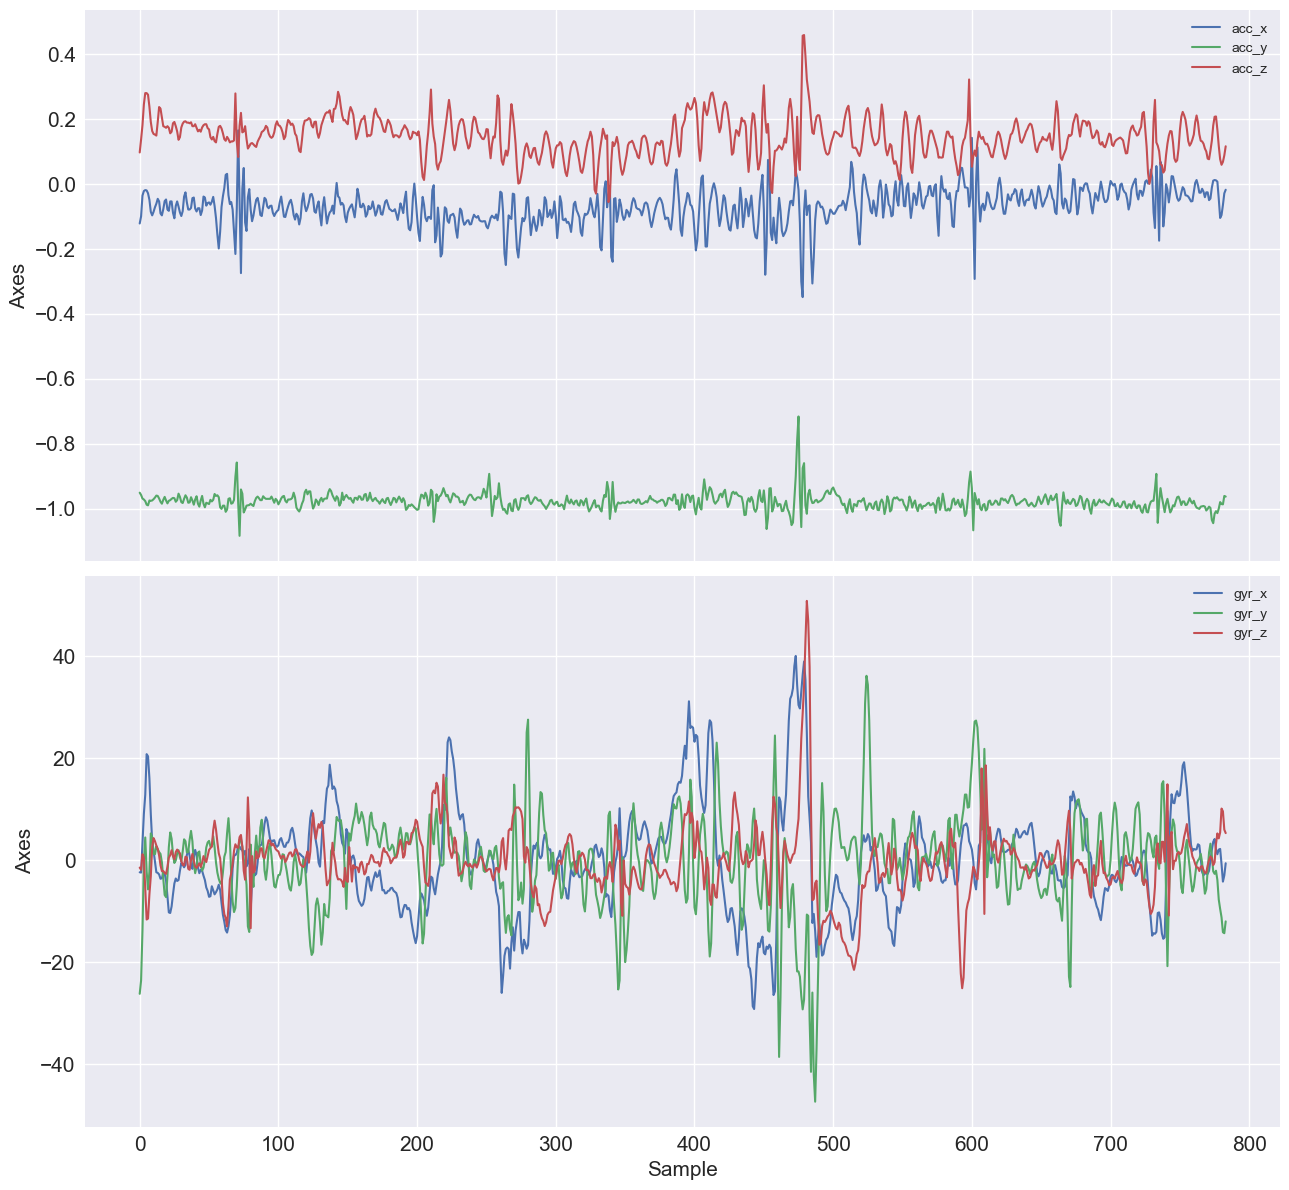

In [12]:
# shake gesture sample
plot_instance_time_domain(cls_c[0])

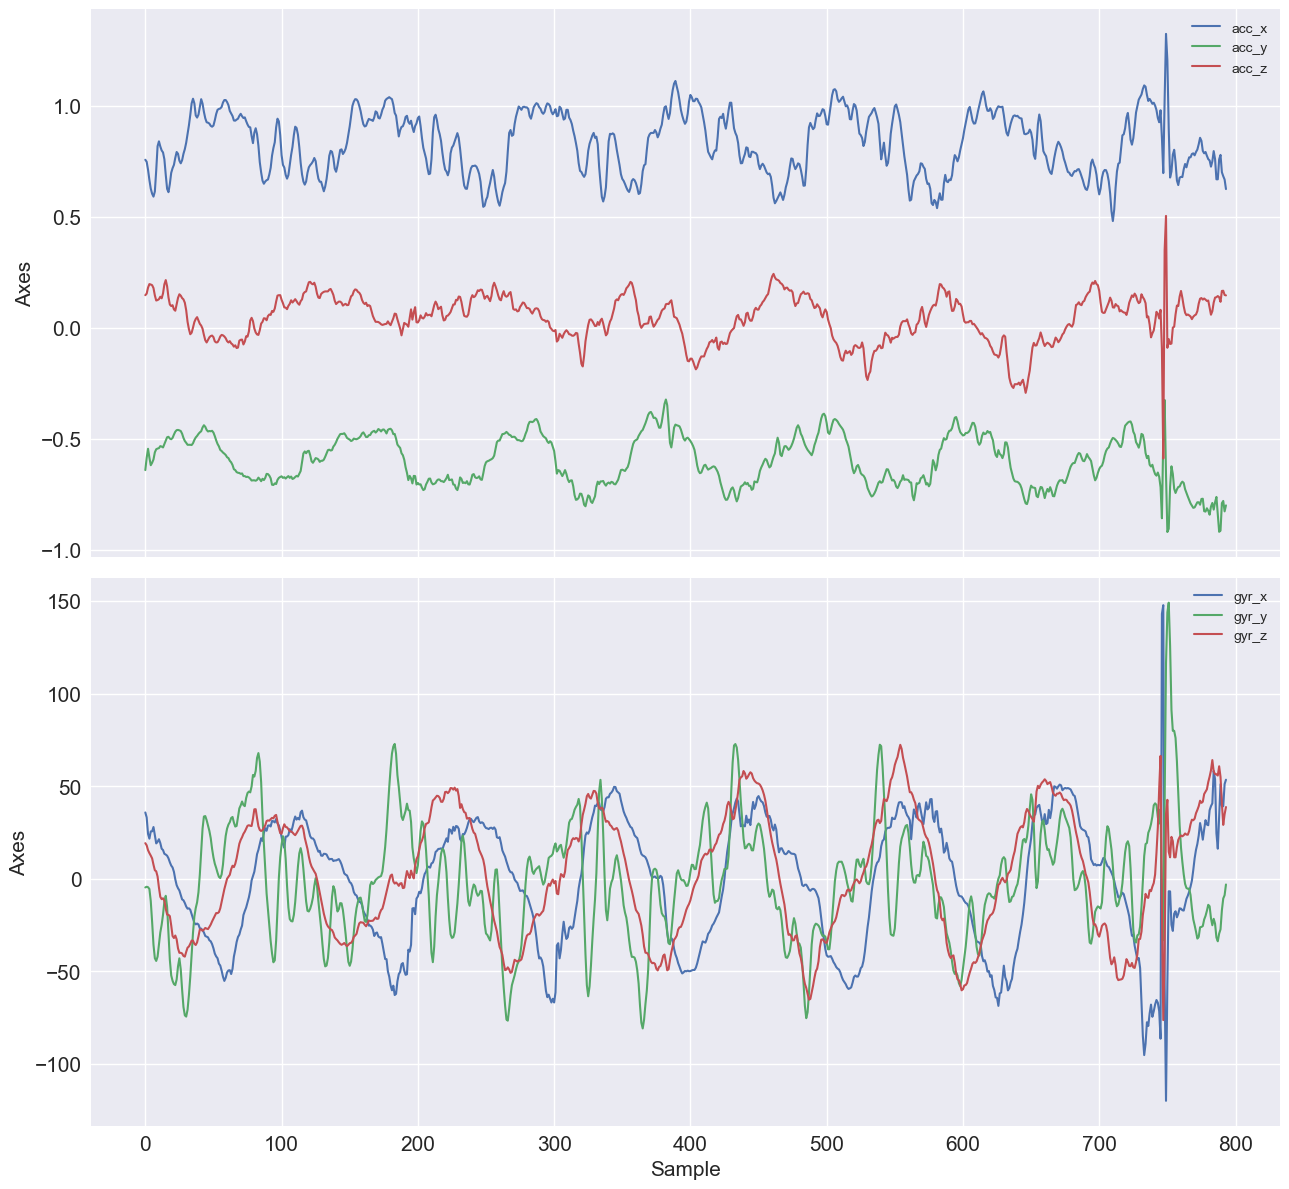

In [13]:
# highfive gesture sample
plot_instance_time_domain(cls_d[0])

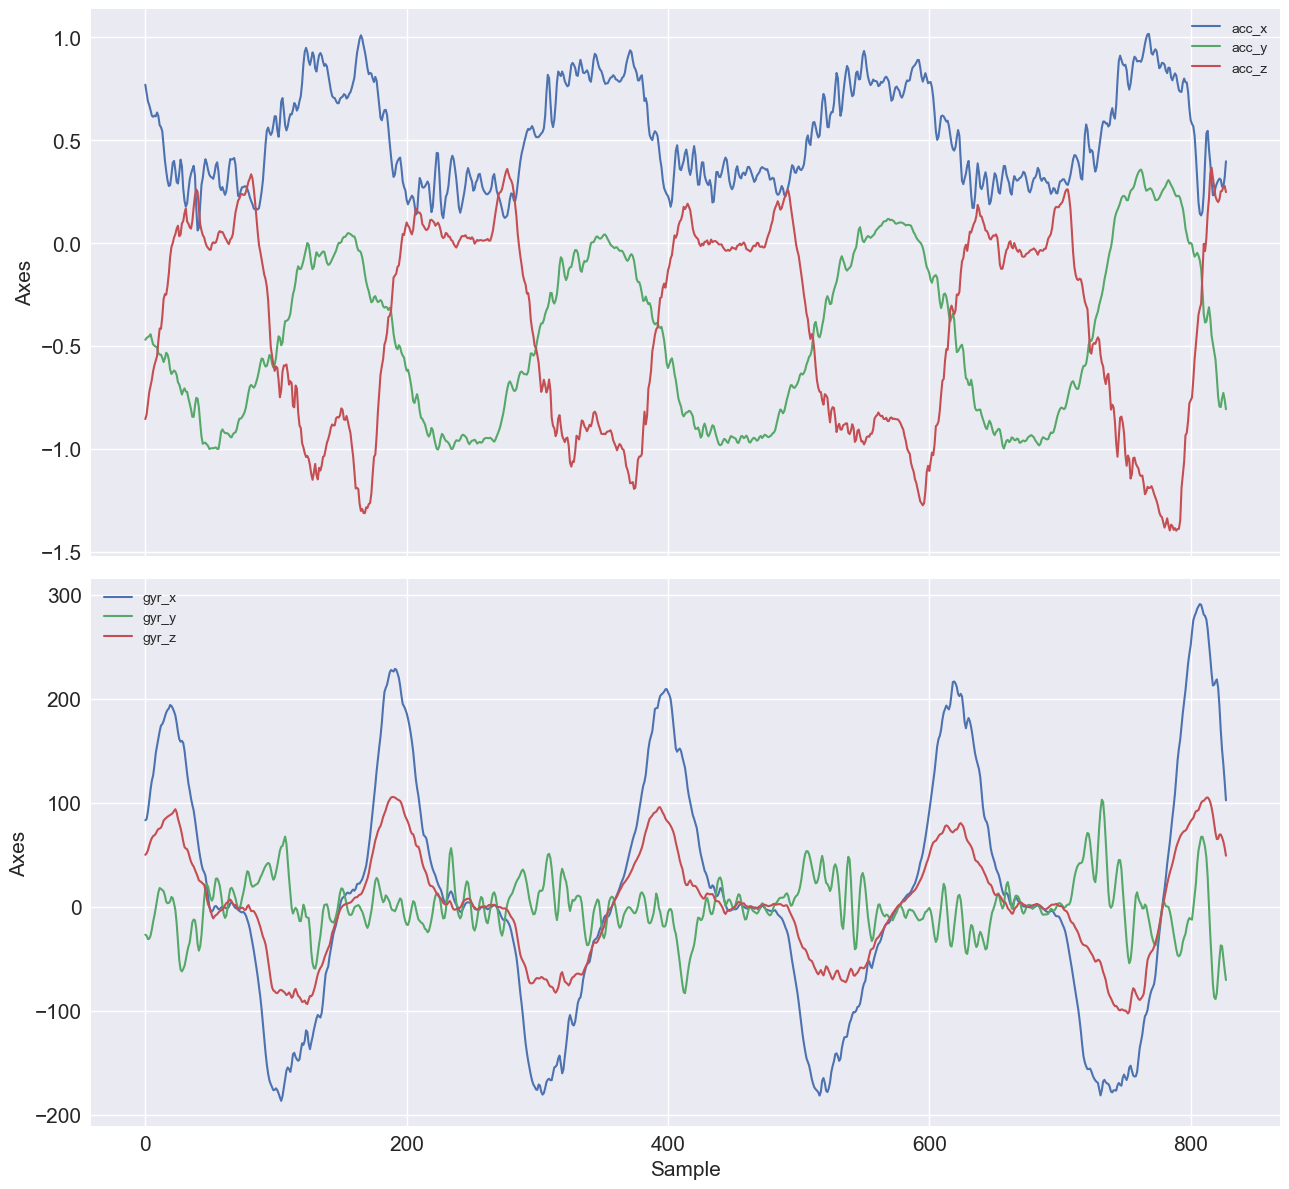

In [14]:
# fistbump gesture sample
plot_instance_time_domain(cls_e[0])

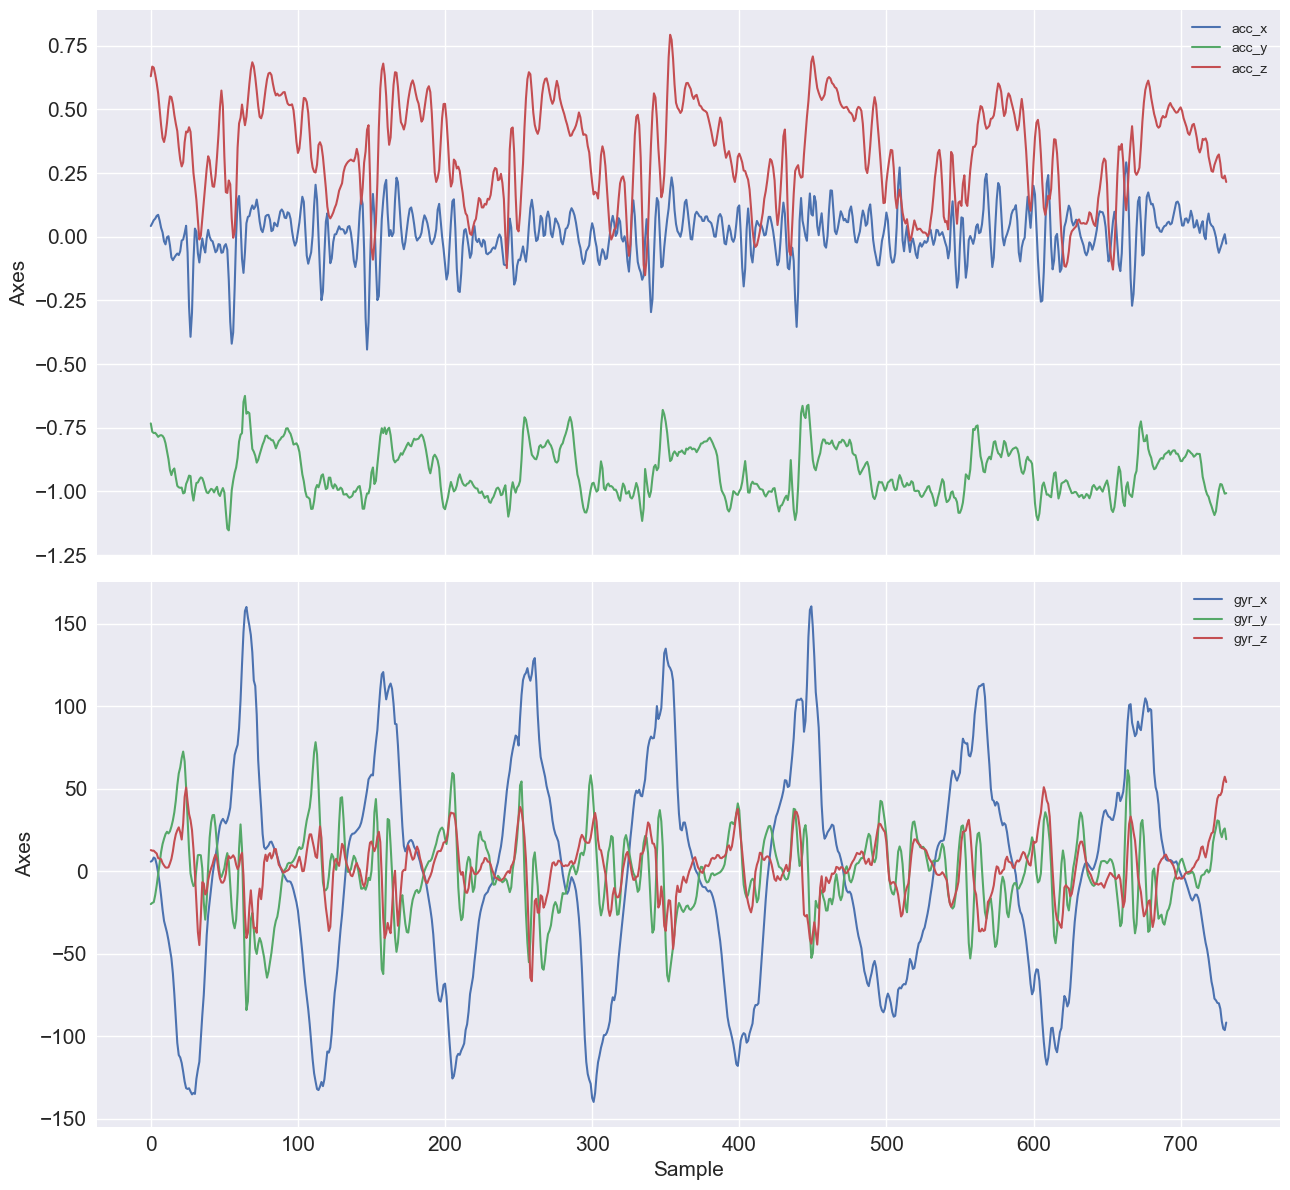

In [17]:
# fistbump gesture sample
plot_instance_time_domain(cls_f[0])

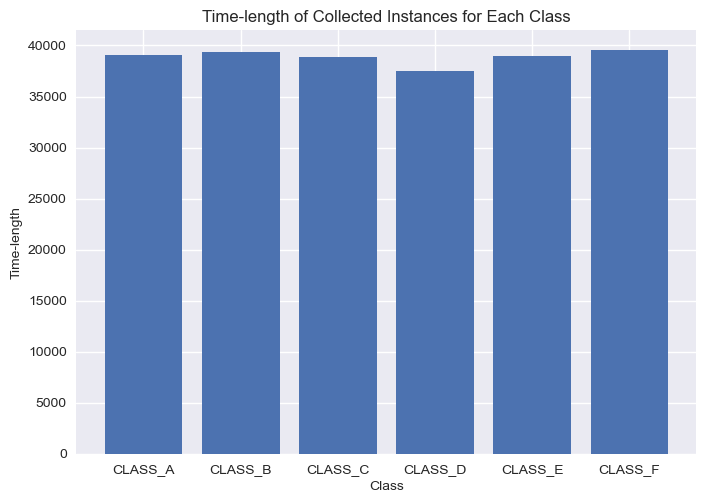

In [18]:
lengths = [sum(session.shape[0] for session in cls) for cls in gestures]

plt.bar(class_labels, lengths)
plt.xlabel('Class')
plt.ylabel('Time-length')
plt.title('Time-length of Collected Instances for Each Class')
plt.show()

In [19]:
# window size is 50 with 50% overlap
sw = config['sliding_window']
sw

{'ws': 150,
 'overlap': 75,
 'w_type': 'hann',
 'w_center': True,
 'print_stats': False}

In [20]:
# augment data with sliding window and append total colleciton together
sliding_window_gestures = [
    [window for df_inst in gesture for window in sliding_window_pd(df_inst, **sw)]
    for gesture in gestures
]

### Barplot with the count of instances that occurred, for each class

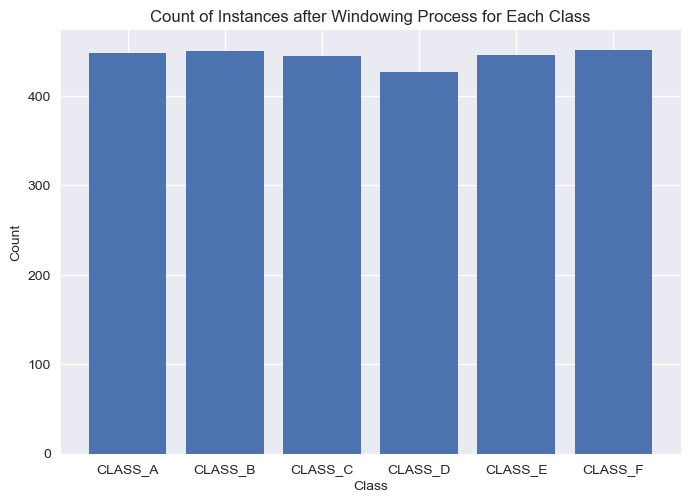

In [21]:
lengths = [len(sw_gesture) for sw_gesture in sliding_window_gestures]

plt.bar(class_labels, lengths)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Instances after Windowing Process for Each Class')
plt.show()

In [22]:
# Concatenate all data together
# Now, each window(df) from each class is a potential training sample/instance
data = [df_inst for sw_gesture in sliding_window_gestures for df_inst in sw_gesture]
data[0].shape

(150, 6)

### Transform the data into the frequency domain

In [23]:
frequency_domain_data = transform_to_frequency_domain(data)

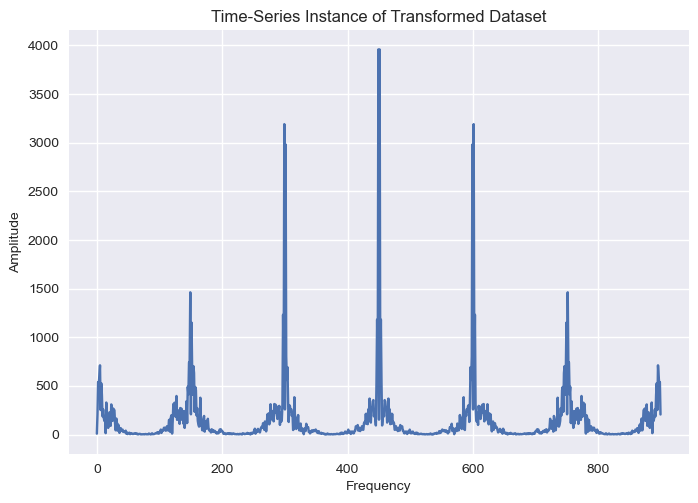

In [24]:
# Visualizing the FT of the first instance
instance_to_visualize = frequency_domain_data[0]

plt.plot(instance_to_visualize)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Time-Series Instance of Transformed Dataset')
plt.show()

### Average cut off frequency to filter data

In [25]:
avg_cutoff_frequency = calculate_avg_cutoff_frequency(frequency_domain_data)
avg_cutoff_frequency

0.317

### Determing the order of the filter

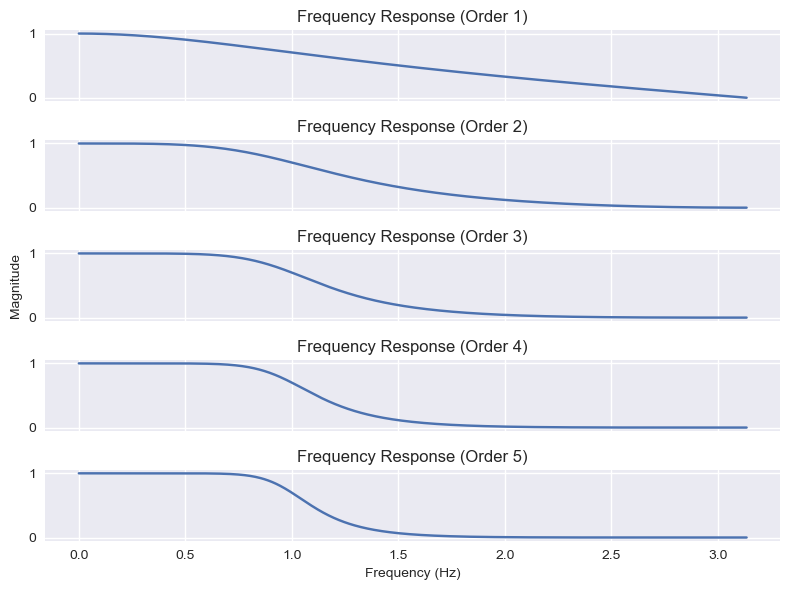

In [26]:
from scipy.signal import butter, freqz

# Range of filter orders to search
orders = np.arange(1, 6)

fig, axs = plt.subplots(len(orders), 1, figsize=(8, 6), sharex=True)

for i, order in enumerate(orders):
    # Design the filter
    b, a = butter(N=order, Wn=avg_cutoff_frequency, btype='low', analog=False)

    # Compute the frequency response
    w, h = freqz(b, a)

    # Plot the frequency response
    axs[i].plot(w, abs(h), label=f'Order {order}')
    axs[i].set_title(f'Frequency Response (Order {order})')

axs[-1].set_xlabel('Frequency (Hz)')
axs[len(orders)//2].set_ylabel('Magnitude')
plt.tight_layout()
plt.show()

In [27]:
# AIC optimization criterion to find the optimal filter order
best_order = find_best_order_aic(orders, avg_cutoff_frequency)
print(f"Best order (AIC): {best_order}")

Best order (AIC): 5


### Filter the data with a low-pass filter at a frequency of X Hz.

In [28]:
filter_prms = config['filter']
filter_prms

{'order': 5, 'wn': 0.212, 'ftype': 'lowpass'}

In [29]:
filter_prms['wn'] = avg_cutoff_frequency
filter_prms

{'order': 5, 'wn': 0.317, 'ftype': 'lowpass'}

In [30]:
filtered_data = filter_instances(data, **filter_prms)

Number of filtered instances in the list: 2667


## Data Preparation

In [31]:
classes = np.arange(len(class_labels))
classes

array([0, 1, 2, 3, 4, 5])

In [32]:
# target value for each sample (y)
labels = np.repeat(classes, lengths)

In [33]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5])

In [34]:
# Determine the dimensions
instances = len(filtered_data)
x = filtered_data[0].shape[0]
y = filtered_data[0].shape[1]
instances,x,y

(2667, 150, 6)

In [35]:
# Convert the list of DataFrames to a NumPy array
X = np.array([df.to_numpy().T for df in filtered_data])
X.shape

(2667, 6, 150)

In [36]:
# Flatten the reshaped array
X_flattened = X.reshape(instances, -1)
X_flattened.shape

(2667, 900)

## Train/Test split

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_flattened.shape, labels.shape

((2667, 900), (2667,))

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, labels, test_size=0.2, shuffle=True, random_state=42)

In [40]:
X_train.shape, X_test.shape

((2133, 900), (534, 900))

## Scaling

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [42]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
X_flattened_scaled = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)
X_flattened_scaled.shape

(2667, 900)

## Transform to 2D again

In [44]:
X_scaled = np.array([arr.reshape(x, y) for arr in X_flattened_scaled])
X_scaled.shape

(2667, 150, 6)

## Dimensionality Reduction with PCA using the 1D (flattened) data

In [45]:
from sklearn.decomposition import PCA

### PCA with 2 Components

In [46]:
pca2d = PCA(n_components=2).fit(X_flattened_scaled)
pca2d_data = pca2d.transform(X_flattened_scaled)

In [47]:
X_flattened_scaled.shape, pca2d_data.shape

((2667, 900), (2667, 2))

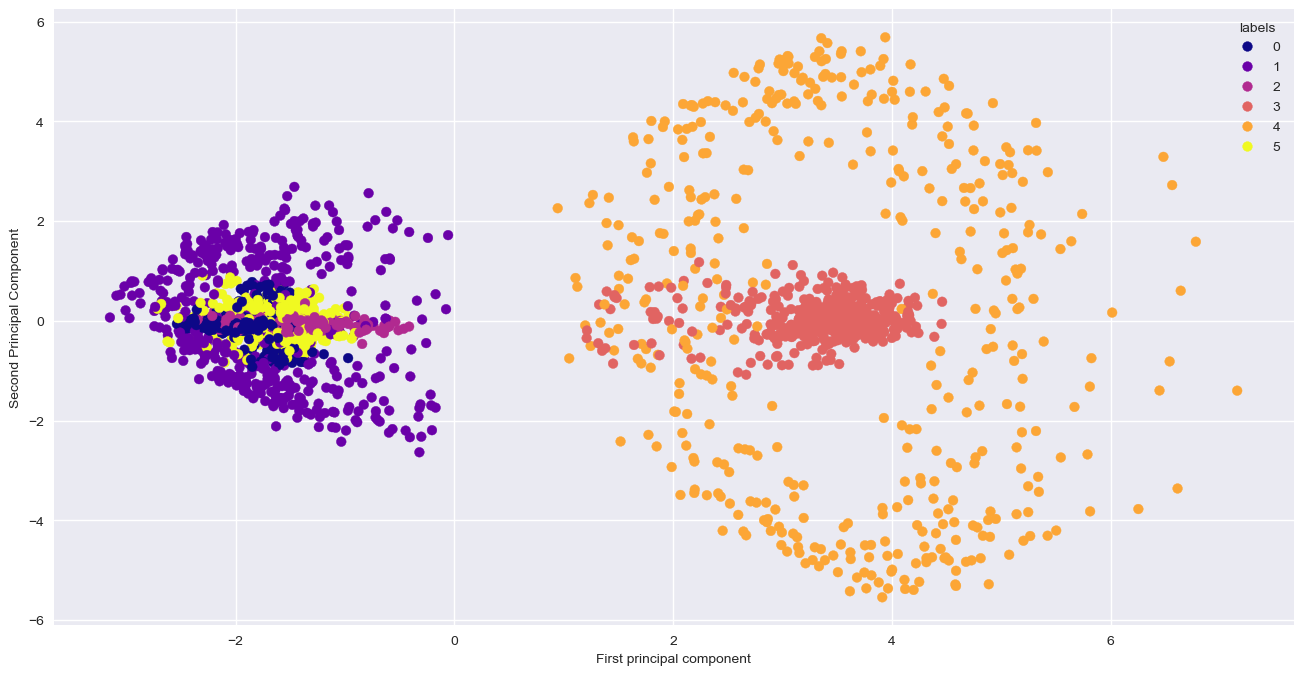

In [48]:
pca2d_df = pd.DataFrame({'x': pca2d_data[:, 0], 'y': pca2d_data[:, 1], 'labels': labels})
plot_scatter_pca(pca2d_df, 'labels')
# goodbye, no and yes

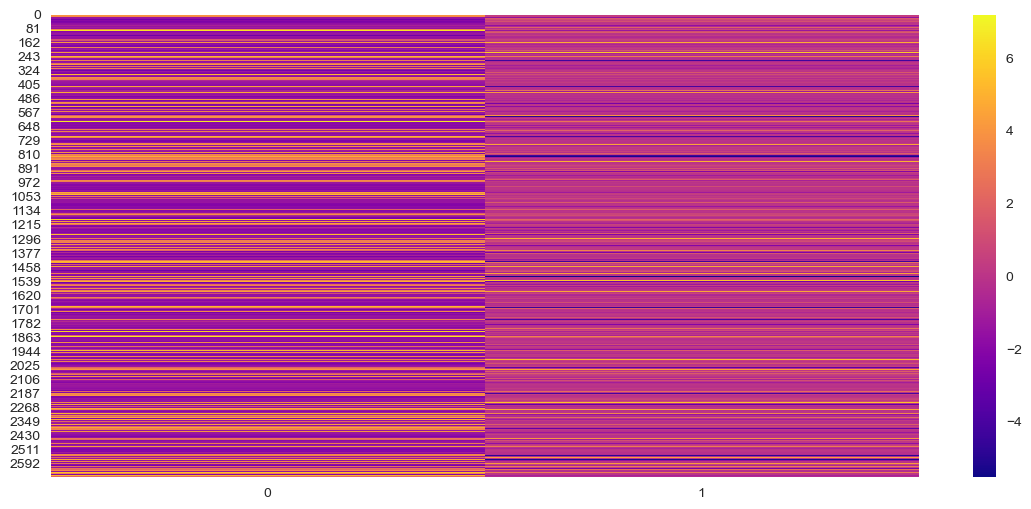

In [49]:
plot_heatmap(pca2d_data)

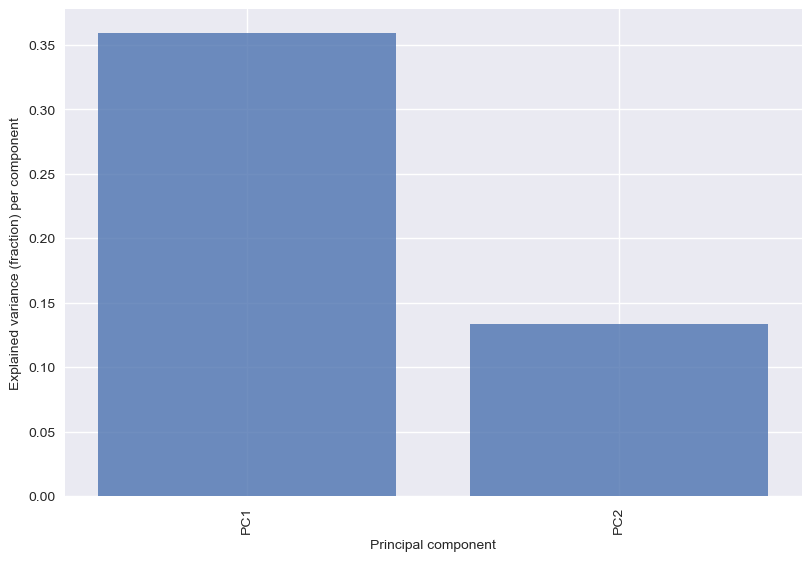

In [50]:
pca_explained_variance_bar(pca2d, alpha=0.8)
plt.show()

### PCA with 3 Components

In [51]:
pca3d = PCA(n_components=3).fit(X_flattened_scaled)
pca3d_data = pca3d.transform(X_flattened_scaled)

In [52]:
pca3d_df = pd.DataFrame(pca3d_data, columns=['x', 'y', 'z'])
pca3d_df['labels'] = labels

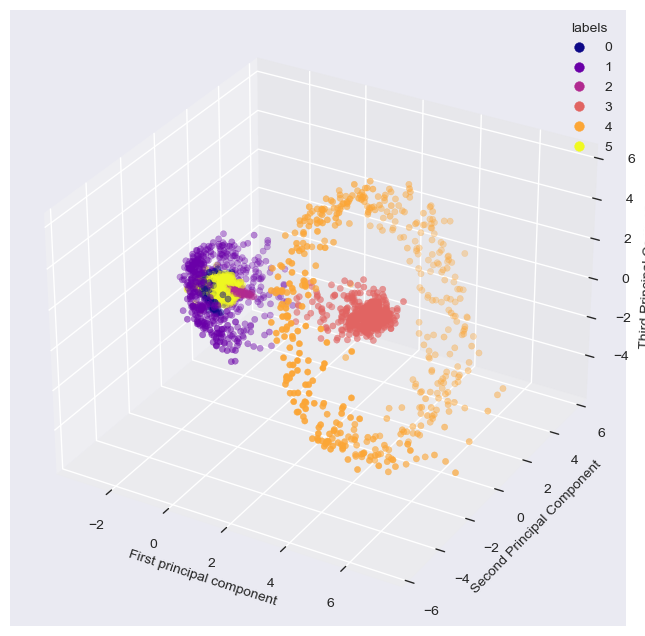

In [53]:
plot_scatter_pca(pca3d_df, 'labels')

## Leaving out 6th class

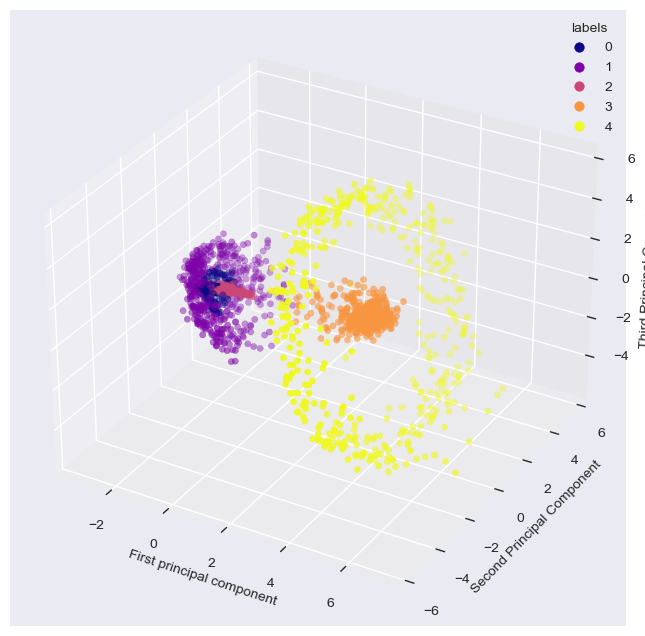

In [54]:
mask_indices = ~(labels == 5)
plot_scatter_pca(pca3d_df.iloc[mask_indices, :], 'labels')

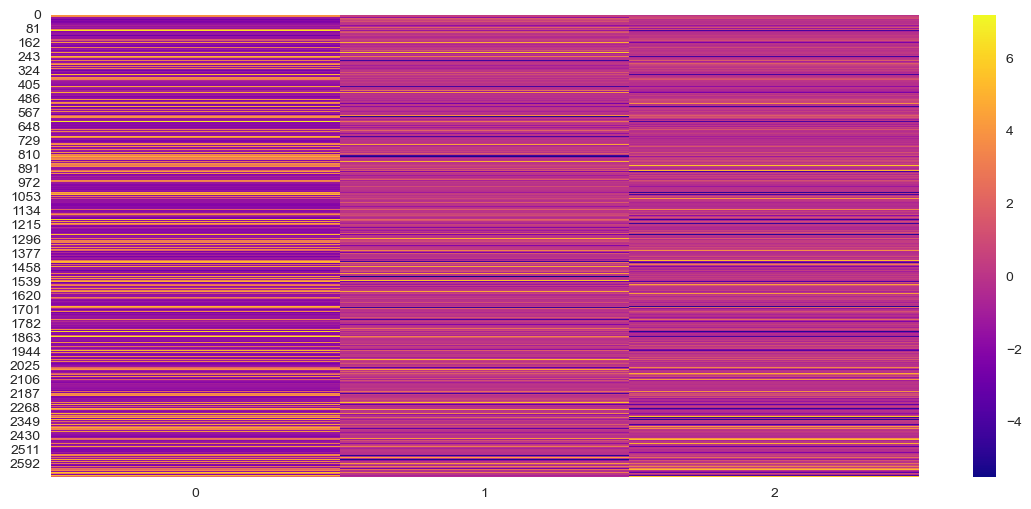

In [55]:
plot_heatmap(pca3d_data)

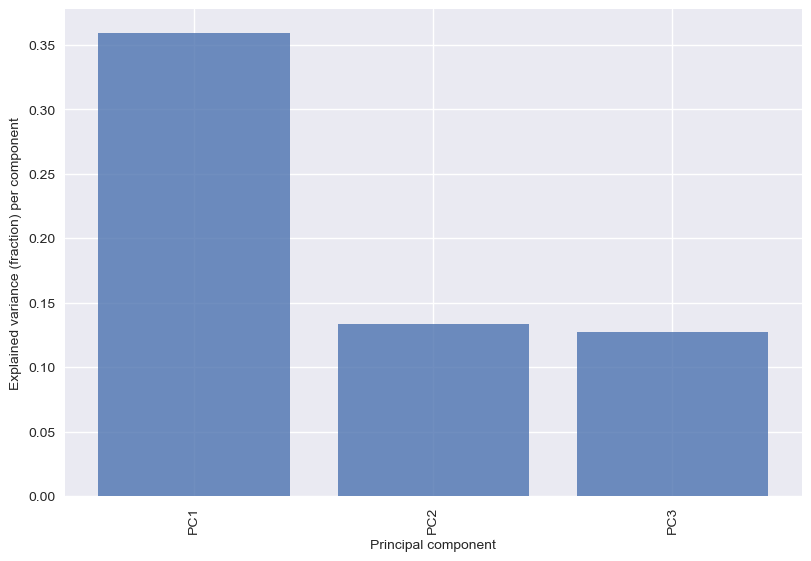

In [56]:
pca_explained_variance_bar(pca3d, alpha=0.8)
plt.show()

### PCA with X% of the variance of the dataset, for training the statistical AI Models

In [57]:
# Find the optimal components for variance percentage to retain
variance_threshold = .9

In [58]:
pca_var = PCA(variance_threshold)
X_pca_var = pca_var.fit_transform(X_flattened_scaled)

# Check the shape of the transformed dataset
print("Original shape:", X_flattened_scaled.shape)
print("Transformed shape:", X_pca_var.shape)

Original shape: (2667, 900)
Transformed shape: (2667, 12)


In [59]:
pca_prms = config['PCA']
pca_prms

{'n_comp': 20}

## Classifier - Statistical Learning

In [60]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Classify with initial (instances X (cols * window)) scaled data

#### SVM Classifier

In [61]:
# Create an SVM classifier
classifier = SVC()

# Train the classifier
classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_scaled)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9456928838951311


#### SVM Evaluation

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [63]:
cm = confusion_matrix(y_test, y_pred, labels=np.unique(labels))
cm

array([[88,  0,  3,  0,  0,  0],
       [ 0, 86,  0,  0,  0,  0],
       [12,  0, 75,  0,  0,  3],
       [ 0,  0,  0, 92,  0,  0],
       [ 0,  0,  0,  0, 93,  0],
       [ 6,  0,  5,  0,  0, 71]], dtype=int64)

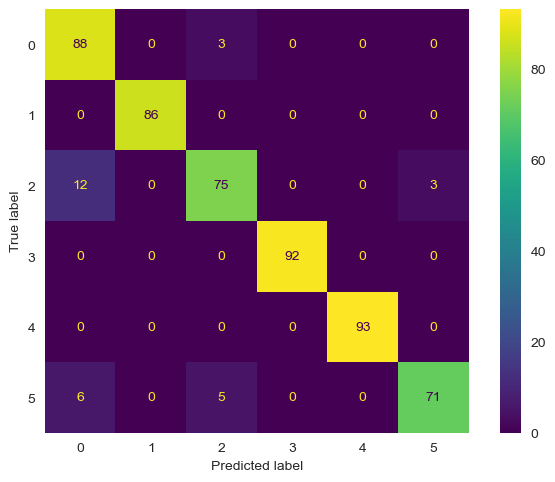

In [64]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.grid(False)

In [65]:
print("SVM Classification Report: \n", classification_report(y_test, y_pred))

SVM Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.97      0.89        91
           1       1.00      1.00      1.00        86
           2       0.90      0.83      0.87        90
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        93
           5       0.96      0.87      0.91        82

    accuracy                           0.95       534
   macro avg       0.95      0.94      0.95       534
weighted avg       0.95      0.95      0.95       534



## Classify with dimensionally reduced data (based on desired variance)

In [66]:
# Split the data into training and testing sets
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca_var, labels, test_size=0.2, shuffle=True, random_state=42)

In [67]:
models = []
accuracies = []

### SVM Classifier

In [68]:
# Create an SVM classifier
classifier = SVC()

# Train the classifier
classifier.fit(X_pca_train, y_pca_train)

# Make predictions on the test set
y_pred = classifier.predict(X_pca_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_pca_test, y_pred)
accuracies += [accuracy]
print("Accuracy:", accuracy)

Accuracy: 0.9325842696629213


#### SVM Evaluation

In [69]:
cm = confusion_matrix(y_pca_test, y_pred, labels=np.unique(labels))
cm

array([[87,  0, 11,  0,  0,  0],
       [ 0, 98,  0,  0,  0,  0],
       [17,  0, 75,  0,  0,  0],
       [ 0,  0,  0, 81,  0,  0],
       [ 0,  0,  0,  1, 89,  0],
       [ 4,  0,  3,  0,  0, 68]], dtype=int64)

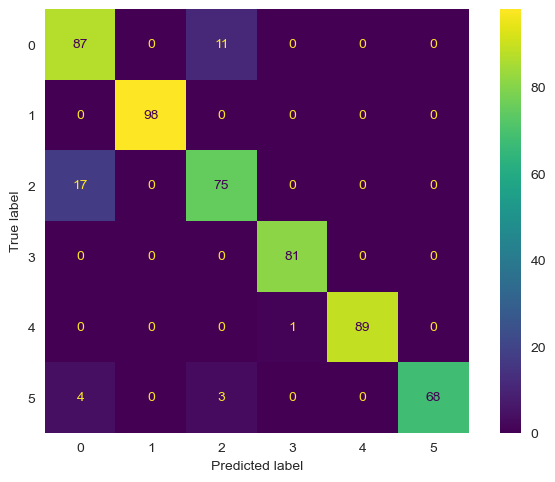

In [70]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.grid(False)

In [71]:
print("SVM Classification Report: \n", classification_report(y_pca_test, y_pred))

SVM Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.89      0.84        98
           1       1.00      1.00      1.00        98
           2       0.84      0.82      0.83        92
           3       0.99      1.00      0.99        81
           4       1.00      0.99      0.99        90
           5       1.00      0.91      0.95        75

    accuracy                           0.93       534
   macro avg       0.94      0.93      0.94       534
weighted avg       0.94      0.93      0.93       534



#### RandomForest Classifier

In [72]:
# Create a Random Forest classifier
classifier = RandomForestClassifier()

# Train the classifier
classifier.fit(X_pca_train, y_pca_train)

# Make predictions on the test set
y_pred = classifier.predict(X_pca_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_pca_test, y_pred)
accuracies += [accuracy]
print("Accuracy:", accuracy)

Accuracy: 0.9831460674157303


#### RandomForest Classifier Evaluation

In [73]:
cm = confusion_matrix(y_pca_test, y_pred, labels=np.unique(labels))
cm

array([[96,  0,  1,  0,  0,  1],
       [ 0, 98,  0,  0,  0,  0],
       [ 6,  0, 86,  0,  0,  0],
       [ 0,  0,  0, 81,  0,  0],
       [ 0,  0,  0,  1, 89,  0],
       [ 0,  0,  0,  0,  0, 75]], dtype=int64)

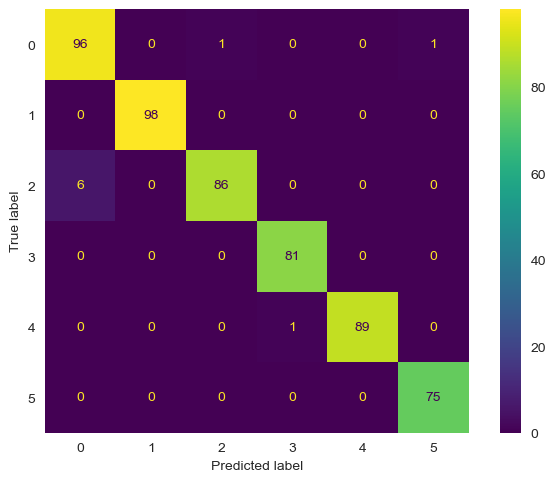

In [74]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.grid(False)

In [75]:
print("RandomForest Classification Report: \n", classification_report(y_pca_test, y_pred))

RandomForest Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        98
           1       1.00      1.00      1.00        98
           2       0.99      0.93      0.96        92
           3       0.99      1.00      0.99        81
           4       1.00      0.99      0.99        90
           5       0.99      1.00      0.99        75

    accuracy                           0.98       534
   macro avg       0.98      0.98      0.98       534
weighted avg       0.98      0.98      0.98       534



### Optimization with Grid Search and Cross-validation

In [76]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [77]:
fine_tune_params = config['fine_tune']

In [78]:
linear_prms, rfb_prms = fine_tune_params['param_grid']
cv, verb = fine_tune_params['cv'], fine_tune_params['verbose']
linear_prms, rfb_prms, cv, verb

({'C': [1, 10, 100, 1000], 'kernel': ['linear']},
 {'C': [1, 10, 100, 1000], 'gamma': [0.3, 0.2, 0.1, 0.01], 'kernel': ['rbf']},
 5,
 1)

In [81]:
grid_search  = GridSearchCV(SVC(), [linear_prms, rfb_prms], cv=cv, verbose=verb)
grid_search.fit(X_pca_train, y_pca_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.3, 0.2, 0.1, 0.01], 'kernel': ['rbf']}],
             verbose=1)

In [82]:
# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluate the model on the test set using the best parameters
best_model = grid_search.best_estimator_
test_score = best_model.score(X_pca_test, y_pca_test)
accuracies += [test_score]
print("Test set score: ", test_score)

Best parameters:  {'C': 1000, 'gamma': 0.3, 'kernel': 'rbf'}
Best score:  0.9849963166980021
Test set score:  1.0


### Optimized classifier evaluation

In [83]:
grid_search.best_params_

{'C': 1000, 'gamma': 0.3, 'kernel': 'rbf'}

In [84]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X_pca_var, labels, cv=cv)
scores

array([0.99250936, 0.98689139, 0.99061914, 0.98874296, 0.98686679])

In [85]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.99 accuracy with a standard deviation of 0.00


## Classifier - Neural Network

In [86]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten

In [87]:
input_data_shape = X_scaled[0].shape
print("Type of the input shape object:", type(input_data_shape))
input_data_shape

Type of the input shape object: <class 'tuple'>


(150, 6)

In [88]:
n_outputs = len(np.unique(labels))
print("Number of outputs (classes) the model to predict:", n_outputs)

Number of outputs (classes) the model to predict: 6


### Neural Network (NN) Architecture and model instantiation

In [89]:
# Define the CNN architecture
model = Sequential()

# 64 filters, kernel size 6, input shape (window, cols)
model.add(Conv1D(64, 6, activation='relu', input_shape=input_data_shape))
model.add(MaxPooling1D(2))

# 128 filters, kernel size 6
model.add(Conv1D(128, 6, activation='relu'))
model.add(MaxPooling1D(2))

# final fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation="softmax"))  # Output layer with sigmoid activation for classification

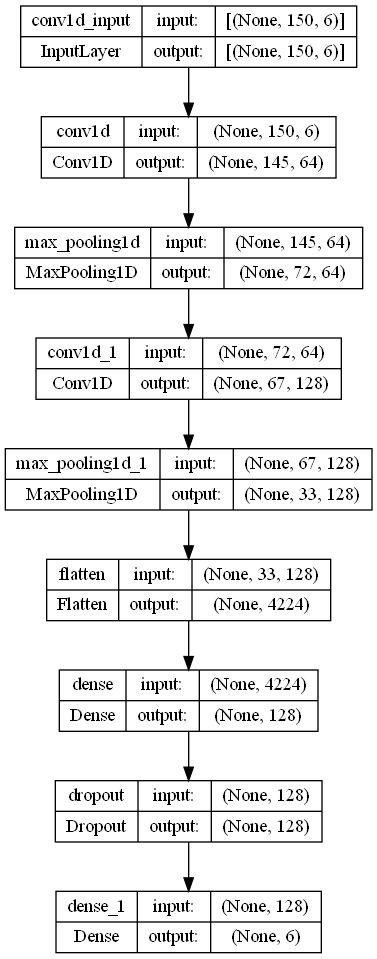

In [90]:
# Plot the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [91]:
# Plot the summary of the TensorFlow model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 145, 64)           2368      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 72, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 67, 128)           49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 33, 128)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 4224)              0         
                                                                 
 dense (Dense)               (None, 128)               5

In [92]:
# Build the NN model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# sparse categorical because it's not one hot encoded by we are actually trying to predict the actul (integer)value of the class

### NN model Training

#### Spliting data into training, test and validation

In [93]:
total_samples = X_scaled.shape[0]

train_size = int(0.7 * total_samples)
test_size = int(0.15 * total_samples)
val_size = int(0.15 * total_samples)

In [94]:
X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:train_size+test_size]
X_val = X_scaled[train_size+test_size:]

y_train = labels[:train_size]
y_test = labels[train_size:train_size+test_size]
y_val = labels[train_size+test_size:]

In [95]:
nn_prms = config['fit']
nn_prms

{'epochs': 10, 'batch': 16, 'verbose': 'auto'}

In [96]:
# Train the model
tf.data.experimental.enable_debug_mode()
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose='auto')

Epoch 1/50
59/59 [==============================] - 2s 27ms/step - loss: 1.3262 - accuracy: 0.4432 - val_loss: 0.6033 - val_accuracy: 0.7880
Epoch 2/50
59/59 [==============================] - 1s 21ms/step - loss: 0.5685 - accuracy: 0.7669 - val_loss: 0.3471 - val_accuracy: 0.8953
Epoch 3/50
59/59 [==============================] - 1s 18ms/step - loss: 0.3957 - accuracy: 0.8382 - val_loss: 0.2626 - val_accuracy: 0.9252
Epoch 4/50
59/59 [==============================] - 1s 18ms/step - loss: 0.3085 - accuracy: 0.8751 - val_loss: 0.2220 - val_accuracy: 0.9327
Epoch 5/50
59/59 [==============================] - 1s 19ms/step - loss: 0.2612 - accuracy: 0.9030 - val_loss: 0.1601 - val_accuracy: 0.9277
Epoch 6/50
59/59 [==============================] - 1s 21ms/step - loss: 0.2494 - accuracy: 0.9014 - val_loss: 0.1577 - val_accuracy: 0.9551
Epoch 7/50
59/59 [==============================] - 1s 22ms/step - loss: 0.2684 - accuracy: 0.8939 - val_loss: 0.1776 - val_accuracy: 0.9152
Epoch 8/50
59

### NN model evaluation

In [97]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test.reshape(-1, *input_data_shape), y_test)
accuracies += [test_accuracy]
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

13/13 [==============================] - 0s 10ms/step - loss: 0.0687 - accuracy: 0.9825
Test Loss: 0.06867843866348267
Test Accuracy: 0.9825000166893005


### Loss and Accuracy based on the training and validation sets

In [98]:
from utils_visual import plot_metrics

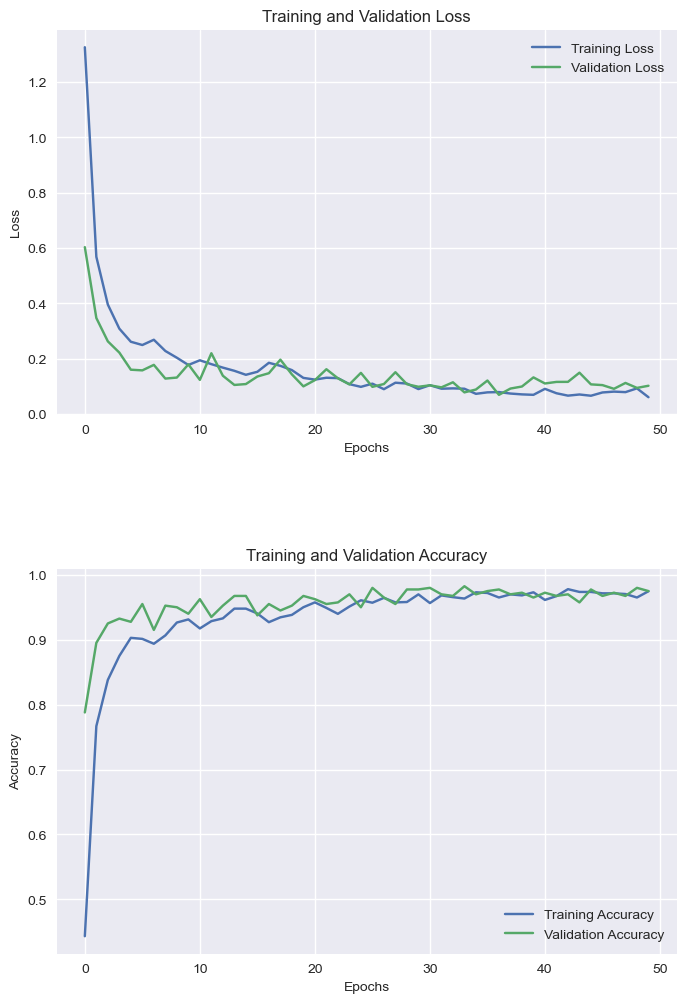

In [99]:
plot_metrics(history)

### RNN Architecture

#### LSTM

In [100]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

# Define the RNN (LSTM) architecture

model = Sequential()
model.add(LSTM(256, input_shape=input_data_shape, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 256)          269312    
                                                                 
 dropout_1 (Dropout)         (None, 150, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [101]:
# Build the NN model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [102]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
59/59 [==============================] - 29s 396ms/step - loss: 2.9206 - accuracy: 0.1677 - val_loss: 2.5163 - val_accuracy: 0.1646
Epoch 2/10
59/59 [==============================] - 21s 349ms/step - loss: 2.2851 - accuracy: 0.1645 - val_loss: 2.0987 - val_accuracy: 0.1671
Epoch 3/10
59/59 [==============================] - 21s 353ms/step - loss: 1.9969 - accuracy: 0.1704 - val_loss: 1.9188 - val_accuracy: 0.1671
Epoch 4/10
59/59 [==============================] - 21s 355ms/step - loss: 1.8765 - accuracy: 0.1629 - val_loss: 1.8460 - val_accuracy: 0.1671
Epoch 5/10
59/59 [==============================] - 21s 361ms/step - loss: 1.8278 - accuracy: 0.1640 - val_loss: 1.8161 - val_accuracy: 0.1671
Epoch 6/10
59/59 [==============================] - 21s 359ms/step - loss: 1.8077 - accuracy: 0.1672 - val_loss: 1.8039 - val_accuracy: 0.1671
Epoch 7/10
59/59 [==============================] - 22s 378ms/step - loss: 1.7989 - accuracy: 0.1688 - val_loss: 1.7984 - val_accuracy: 0.1671

In [103]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test.reshape(-1, *input_data_shape), y_test)
accuracies += [test_accuracy]
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

13/13 [==============================] - 2s 122ms/step - loss: 1.7962 - accuracy: 0.1450
Test Loss: 1.796159267425537
Test Accuracy: 0.14499999582767487


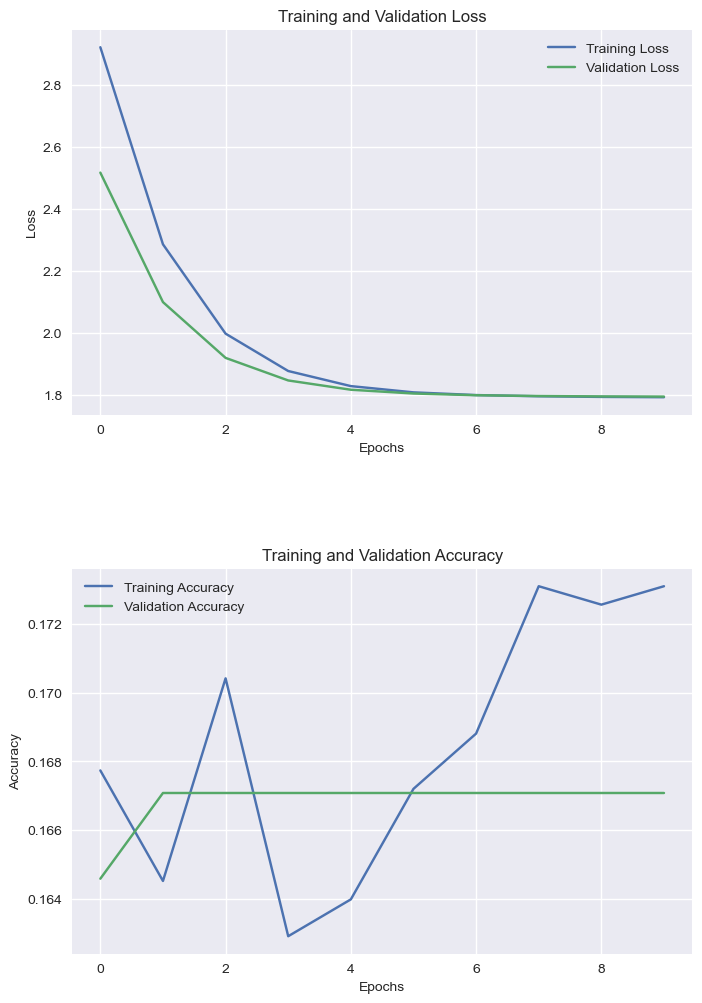

In [104]:
plot_metrics(history)

#### GRU

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define the RNN (GRU) architecture
model = Sequential()
model.add(GRU(254, input_shape=input_data_shape))  # Adjust the units (254) as needed
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 254)               199644    
                                                                 
 dense_5 (Dense)             (None, 128)               32640     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 6)                 390       
                                                                 
Total params: 257,442
Trainable params: 257,442
Non-tr

In [106]:
# Build the NN model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [107]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
59/59 [==============================] - 14s 177ms/step - loss: 4.1007 - accuracy: 0.1635 - val_loss: 2.8972 - val_accuracy: 0.1845
Epoch 2/10
59/59 [==============================] - 10s 162ms/step - loss: 2.4010 - accuracy: 0.1736 - val_loss: 2.0665 - val_accuracy: 0.1397
Epoch 3/10
59/59 [==============================] - 10s 161ms/step - loss: 1.9414 - accuracy: 0.1635 - val_loss: 1.8611 - val_accuracy: 0.1546
Epoch 4/10
59/59 [==============================] - 10s 170ms/step - loss: 1.8302 - accuracy: 0.1715 - val_loss: 1.8123 - val_accuracy: 0.1571
Epoch 5/10
59/59 [==============================] - 12s 195ms/step - loss: 1.8033 - accuracy: 0.1522 - val_loss: 1.8000 - val_accuracy: 0.1571
Epoch 6/10
59/59 [==============================] - 10s 178ms/step - loss: 1.7957 - accuracy: 0.1747 - val_loss: 1.7959 - val_accuracy: 0.1671
Epoch 7/10
59/59 [==============================] - 12s 203ms/step - loss: 1.7930 - accuracy: 0.1640 - val_loss: 1.7946 - val_accuracy: 0.1671

In [108]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test.reshape(-1, *input_data_shape), y_test)
accuracies += [test_accuracy]
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

13/13 [==============================] - 1s 55ms/step - loss: 1.7957 - accuracy: 0.1450
Test Loss: 1.7956959009170532
Test Accuracy: 0.14499999582767487


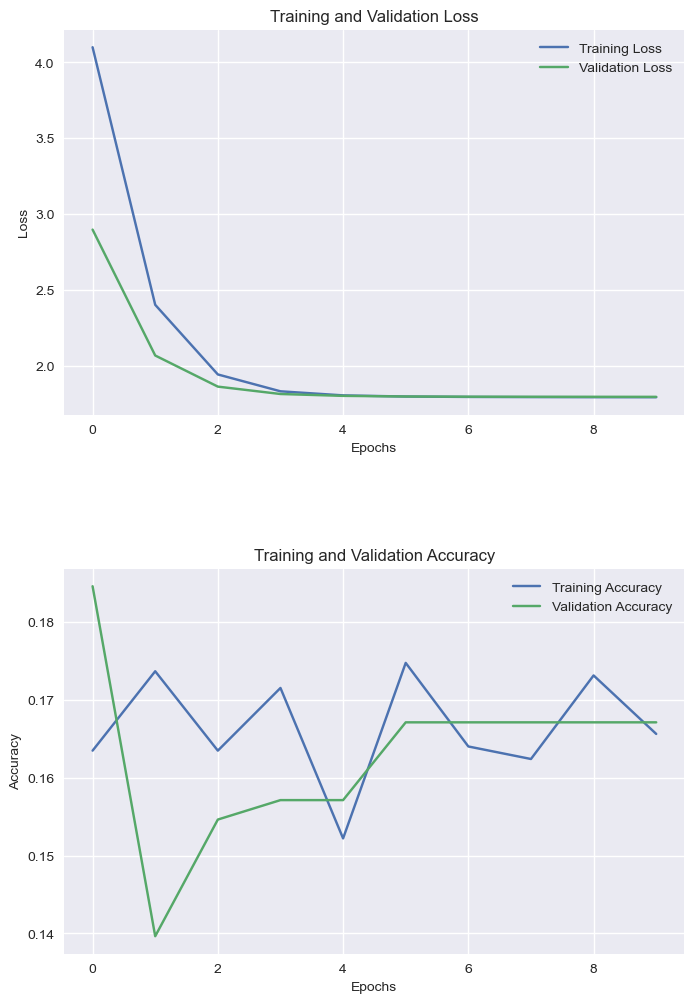

In [109]:
plot_metrics(history)

### Models Evaluation Plot

In [110]:
models = ['SVM-scale', 'RandomForest', 'SVM-optimized', 'CNN', 'LSTM', 'GRU']

[]

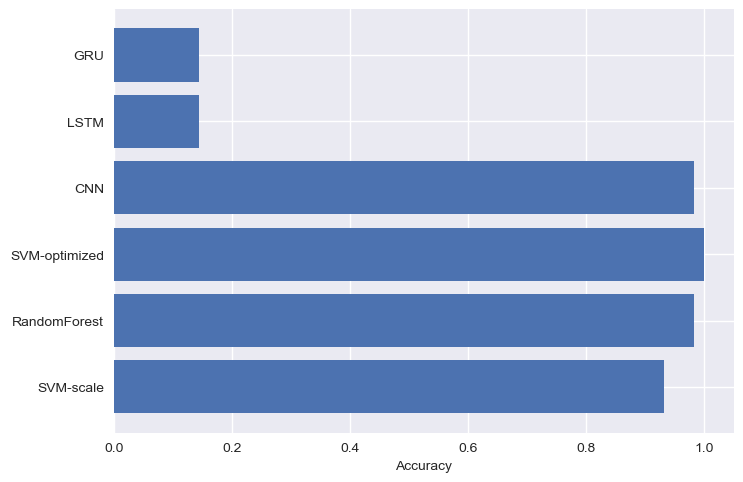

In [111]:
plt.barh(models, accuracies)
plt.xlabel('Accuracy')
plt.plot()

# Interpreting the learning curves

Loss curves: A decreasing training loss and a decreasing validation loss indicate that the model is learning and generalizing well. However, if the training loss continues to decrease while the validation loss starts to increase or plateaus, it could be a sign of overfitting.

Accuracy curves: An increasing training accuracy and a similar increasing validation accuracy indicate that the model is improving and generalizing well. If the training accuracy increases significantly while the validation accuracy lags behind or plateaus, it could be an indication of overfitting.

In [112]:
print(f'Took {(time()-time_start) / 60:.2f} minutes!')

Took 10.15 minutes!
